In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import matplotlib.lines as lines
from receptive_fields.util.experiment_setup import load_model, load_log
from receptive_fields.util.activation_visualization import effective_receptive_field, rescaleZeroOne
from tqdm import tqdm
import torch
from matplotlib.patches import Rectangle
import os.path as osp

In [2]:
pool_networks = ["../models/bottleneck_grid/factor2/pool_large_ks3",
"../models/bottleneck_grid/factor3/pool_large_ks3",
"../models/bottleneck_grid/factor2/pool_large_ks5",
"../models/bottleneck_grid/factor3/pool_large_ks5",
"../models/bottleneck_grid/factor4/pool_large_ks5",
"../models/bottleneck_grid/factor2/pool_large_ks7",
"../models/bottleneck_grid/factor3/pool_large_ks7",
"../models/bottleneck_grid/factor4/pool_large_ks7"]

stride_networks = ["../models/bottleneck_grid/factor2/stride_large_ks3",
"../models/bottleneck_grid/factor3/stride_large_ks3",
"../models/bottleneck_grid/factor2/stride_large_ks5",
"../models/bottleneck_grid/factor3/stride_large_ks5",
"../models/bottleneck_grid/factor4/stride_large_ks5",
"../models/bottleneck_grid/factor2/stride_large_ks7",
"../models/bottleneck_grid/factor3/stride_large_ks7",
"../models/bottleneck_grid/factor4/stride_large_ks7"]

In [3]:
layer = 2
inc_nonlinear = False

layer = layer-1
pool_rfs = []
for mpath in tqdm(pool_networks):
    model = load_model(mpath).get_sequential()
    eff_rfs = effective_receptive_field(model[:1+3*layer + inc_nonlinear], n_batch=1, fill_value=0.0)
    order = torch.argsort(eff_rfs.abs().sum(axis=(1,2,3)), descending=True)
    rel_rfs = eff_rfs[order[:3]]
    pool_rfs.append(rel_rfs)

stride_rfs = []
for mpath in tqdm(stride_networks):
    model = load_model(mpath).get_sequential()
    eff_rfs = effective_receptive_field(model[:1+2*layer + inc_nonlinear], n_batch=1, fill_value=0.0)
    order = torch.argsort(eff_rfs.abs().sum(axis=(1,2,3)), descending=True)
    rel_rfs = eff_rfs[order[:3]]
    stride_rfs.append(rel_rfs)

100%|██████████| 8/8 [00:00<00:00, 13.55it/s]


In [4]:
rfs = []
for i in range(len(pool_rfs)):
    rfs.extend(pool_rfs[i])
    rfs.extend(stride_rfs[i])

In [5]:
pool_log_paths = [osp.join(osp.split(path)[0], "logs",osp.split(path)[1]+".yaml") for path in pool_networks]
stride_log_paths = [osp.join(osp.split(path)[0], "logs",osp.split(path)[1]+".yaml") for path in stride_networks]
pool_logs = [load_log(p) for p in pool_log_paths]
stride_logs = [load_log(p) for p in stride_log_paths]

In [6]:
perf_matrix = np.array(
    [
        [
            np.max(pool_logs[0]["val_acc"]),
            np.max(stride_logs[0]["val_acc"]),
            np.max(pool_logs[1]["val_acc"]),
            np.max(stride_logs[1]["val_acc"]),
            np.nan,
            np.nan,
        ],
        [
            np.max(pool_logs[2]["val_acc"]),
            np.max(stride_logs[2]["val_acc"]),
            np.max(pool_logs[3]["val_acc"]),
            np.max(stride_logs[3]["val_acc"]),
            np.max(pool_logs[4]["val_acc"]),
            np.max(stride_logs[4]["val_acc"]),
        ],
        [
            np.max(pool_logs[5]["val_acc"]),
            np.max(stride_logs[5]["val_acc"]),
            np.max(pool_logs[6]["val_acc"]),
            np.max(stride_logs[6]["val_acc"]),
            np.max(pool_logs[7]["val_acc"]),
            np.max(stride_logs[7]["val_acc"]),
        ],
    ]
)

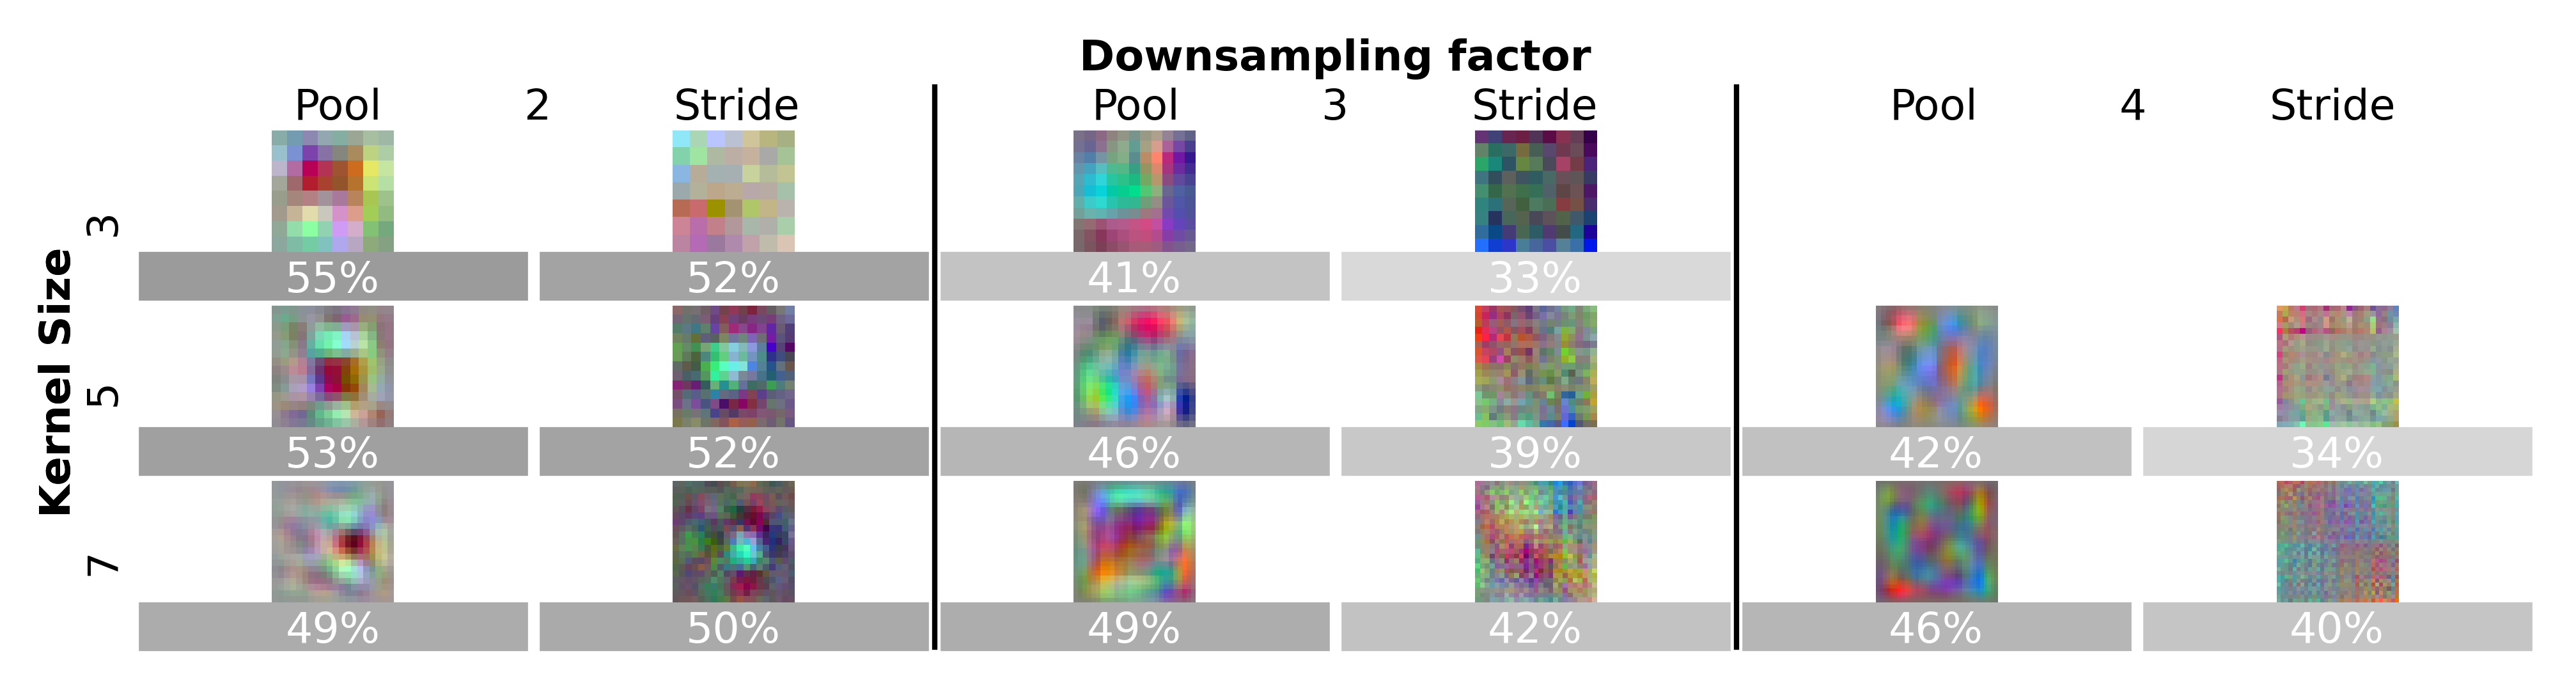

In [7]:
mpl.rcParams['figure.dpi'] = 600

methods = ["Pool", "Stride"]

# Set up the figure and axes
gridspec={"left":0.04, "right":1, "top":0.88, "bottom":0.05, "wspace":0.1, "hspace":0.1}
width = (1-gridspec['left'])
hstep = (gridspec['top']-gridspec['bottom'])/3
fig, axes = plt.subplots(3, 18, figsize=(6.5, 1.6), gridspec_kw=gridspec) # 6.5/gridspec['top']*(1-gridspec['left']) /6

# Populate the subplots
for i, rf in enumerate(rfs):
    if len(rfs) == 16:
        ax_id = i*3+1
        if i > 3:
            ax_id+=6
        axes.flat[ax_id-1].axis('off')
        axes.flat[ax_id+1].axis('off')
    else:
        ax_id = i
        if i>11:
            ax_id+=6
    ax = axes.flat[ax_id]
    ax.imshow(rescaleZeroOne(rf).swapaxes(0,2)[...,-3:])
    ax.axis('off')
for ax in axes.flat[12:18]:
    ax.axis('off')

# Add kernel sizes
for i in range(3):
    fig.text(0.018, gridspec['top']/6+ hstep * i, f'{(3-i)*2 + 1}', rotation='vertical', va='center', ha='left', fontsize=8)

# Add the method labels
for i in range(6):
    fig.text(gridspec['left']+(1-gridspec['left'])/12+ (1-gridspec['left'])/6 * i, 0.92, methods[i % 2], va='top', ha='center', fontsize=8)

# Add downsampling factors
for i in range(3):
    fig.text(gridspec['left']+(1-gridspec['left'])/6+ (1-gridspec['left'])/3 * i, 0.92, f'{i + 2}', va='top', ha='center', fontsize=8)

# Additional axis titles
fig.text(gridspec['left']+width/2, 1, 'Downsampling factor', ha='center', va='top', fontsize=8, weight="bold")
fig.text(0.0, gridspec['top']/2, 'Kernel Size', va='center', ha='left', rotation='vertical', fontsize=8, weight="bold")
fig.text(0.0, gridspec['top']/2, 'Kernel Size', va='center', ha='left', rotation='vertical', fontsize=8, weight="bold")

# Vertical Lines
extra = 0.00025
step = width/18+extra
for i in range(0,7):
    # if i%2 ==0:
        xpos = gridspec["left"]-0.002 + step * i*3
        top = 0.92 if i%2 ==0 else 0.82
        fig.add_artist(lines.Line2D([xpos,xpos], [0.008, top], color="white", linewidth=2.2))
        if i%2==0 and i!=0 and i!=6:
            fig.add_artist(lines.Line2D([xpos,xpos], [0.008, top], color="black", linewidth=1))

hextra = -0.008
hstep = gridspec['top']/3 +hextra
# Horizontal lines
for y in range(3):
    ypos = hstep * (y+0.02)
    for i in range(0,6):
        perf = perf_matrix[2-y,i]
        if not np.isnan(perf):
            xpos = gridspec["left"]-0.001 + step * i*3 - 0.001
            c=1-(perf-20)/90
            fig.patches.append(Rectangle((xpos, ypos), width/6, hstep*0.25, transform=fig.transFigure, color=(c,c,c), alpha=1, zorder=-1))
            fig.text(xpos+width/12, ypos-0.005, str(round(perf))+"%", va='bottom', ha='center', fontsize=8, color="white")
        # fig.add_artist(lines.Line2D([xpos+0.02,xpos+width/6-0.02], [ypos, ypos], color="black", linewidth=15, zorder=1))
# plt.tight_layout()
# plt.savefig('../doc/imgs/rf_comp.png', format='png')